In [9]:
import torch
import torch.nn as nn
import numpy as np

from src.data.box import GravityHoleBall
from src.data.generate import generate_gravity_hole_ball_images

from src.utils.utils import add_spatial_encoding
from src.utils.node import  BatchGetterMultiImages, train_convnode
from src.utils.viz import  display_convnode_trajectory

from src.models.anode import ANODENet
from src.models.convnode import ConvNode


In [10]:
MARGIN_MIN = 5
MIN_INIT_VELOCITY = 200.
WIDTH, HEIGHT = 28, 28
RADIUS = 3

infos = {
    "MARGIN_MIN":MARGIN_MIN,
    "MIN_INIT_VELOCITY":MIN_INIT_VELOCITY,
    "WIDTH":WIDTH,
    "HEIGHT":HEIGHT,
    "RADIUS":RADIUS
}

x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)


Num_pos_velocity = 1
N = 3
N_frames = 300 + Num_pos_velocity
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)
print("-"*50)
print("Generating images...")
images = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt, infos=infos).reshape(-1, 1, HEIGHT, WIDTH)
print(images.shape)
# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)
print(images.shape)


--------------------------------------------------
Generating images...


100%|██████████| 3/3 [00:00<00:00, 27.99it/s]

(903, 1, 28, 28)
torch.Size([3, 301, 3, 28, 28])


In [11]:
print("-"*50)
print("Creating model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
size = HEIGHT
latent_dim = 16
in_channels = 3
ode_data_dim = 25
ode_hidden_dim = 128
augment_dim=0
time_dependent=False
ode_non_linearity='relu' 
conv_activation=nn.ReLU()
latent_activation=None
stack_size=1

conv_ode = ConvNode(device, size, latent_dim, in_channels,
    ode_hidden_dim, ode_data_dim, augment_dim=augment_dim, time_dependent=time_dependent,
    ode_non_linearity=ode_non_linearity, conv_activation=conv_activation,
    latent_activation=latent_activation, stack_size=stack_size)

--------------------------------------------------
Creating model...
--------------------------------------------------
Creating ConvAE...
Number of parameters in the model: 255283
--------------------------------------------------
Creating ANODENet...
Number of parameters in the model: 25689


In [12]:
print("-"*50)
print("Creating tools to train...")
batch_size = 16
batch_time = 200
n_stack = 1
total_length = N_frames - Num_pos_velocity
n_samples = 1
getter = BatchGetterMultiImages(batch_time, n_samples, n_stack, total_length, dt, images, frac_train=1.)

optimizer = torch.optim.Adam(conv_ode.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)
loss_fn = nn.MSELoss()

--------------------------------------------------
Creating tools to train...


In [14]:
root = None #"images/AE_ODE/Gravity/MultiTrajectories/Together/"
name = None # "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
display_fn = lambda i, model, out_display, getter, final_time, dt: display_convnode_trajectory(i, model, out_display, getter, final_time, dt, root=root, name=name)

--------------------------------------------------
Training...


--------------------------------------------------
Training...


  7%|▋         | 199/3000 [07:05<1:38:14,  2.10s/it, Loss: 0.00950621]

The graphs at epoch 200


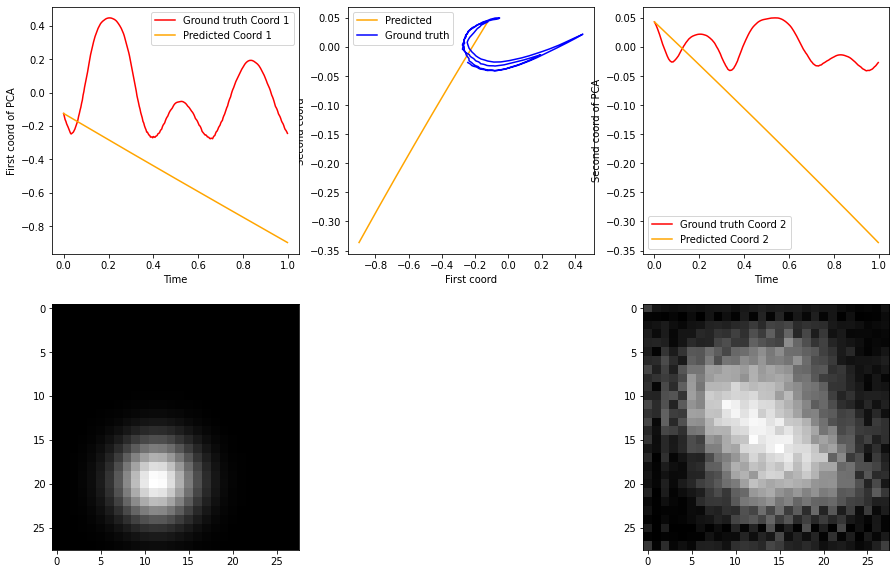

Display loss: 0.01196821:  13%|█▎        | 399/3000 [14:38<1:38:15,  2.27s/it, Loss: 0.00588091]

The graphs at epoch 400


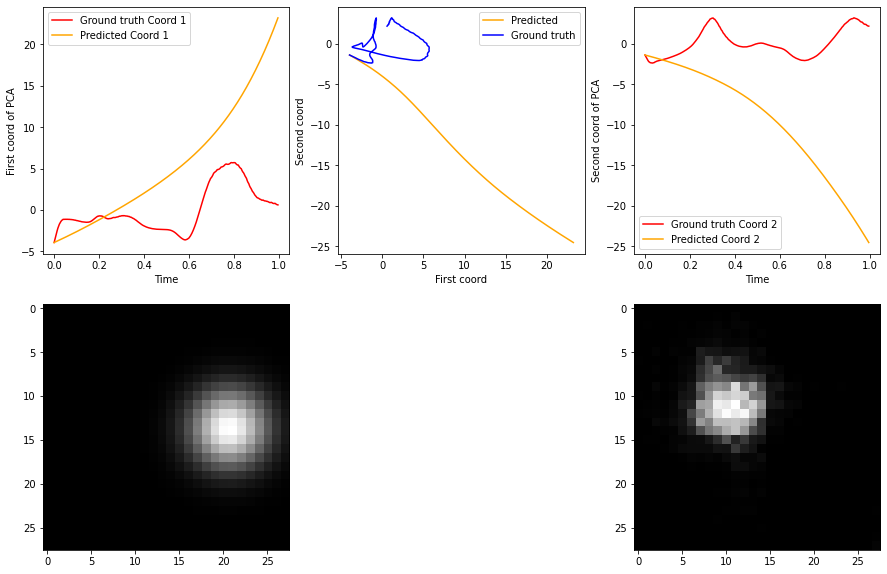

Display loss: 0.00843148:  20%|█▉        | 599/3000 [22:23<1:31:04,  2.28s/it, Loss: 0.00181643]

The graphs at epoch 600


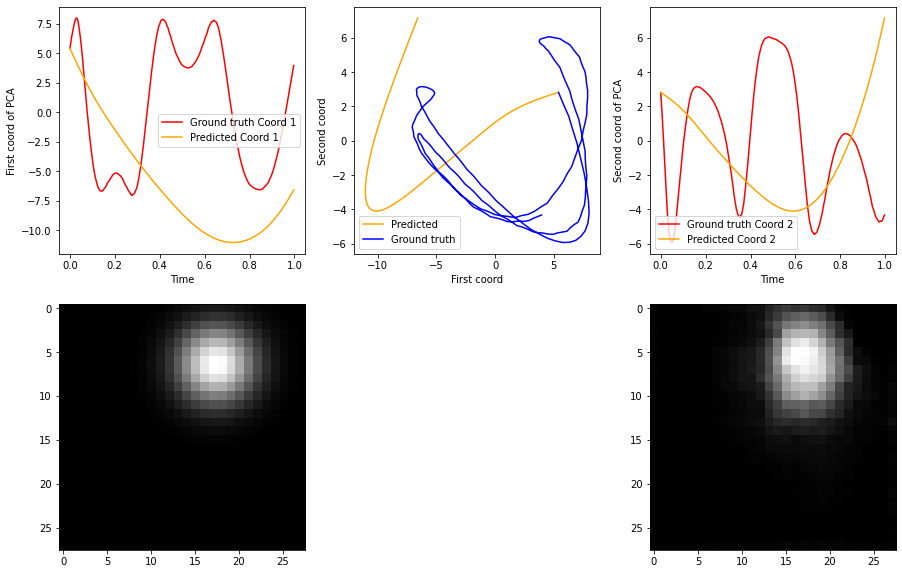

Display loss: 0.00321990:  27%|██▋       | 799/3000 [29:56<1:28:32,  2.41s/it, Loss: 0.00099589]

The graphs at epoch 800


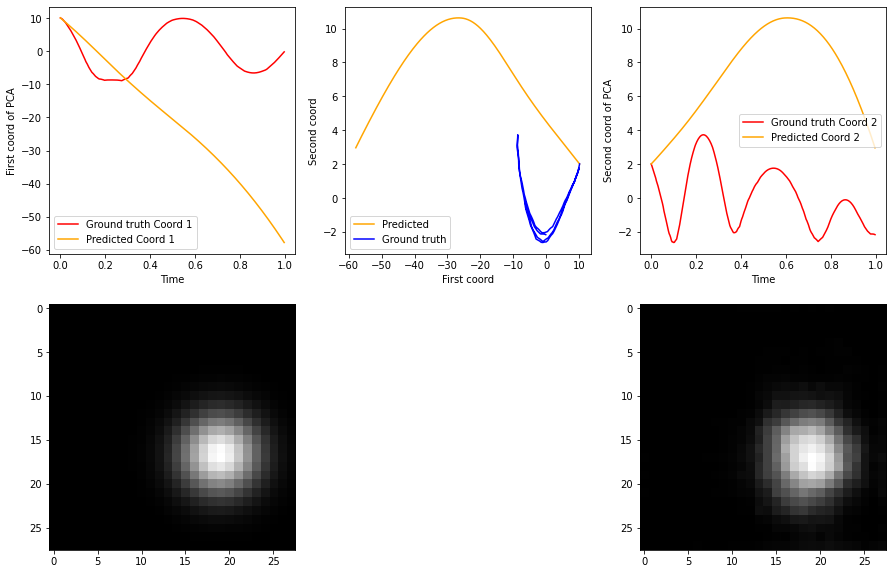

Display loss: 0.00118759:  33%|███▎      | 999/3000 [37:28<1:15:10,  2.25s/it, Loss: 0.00039184]

The graphs at epoch 1000


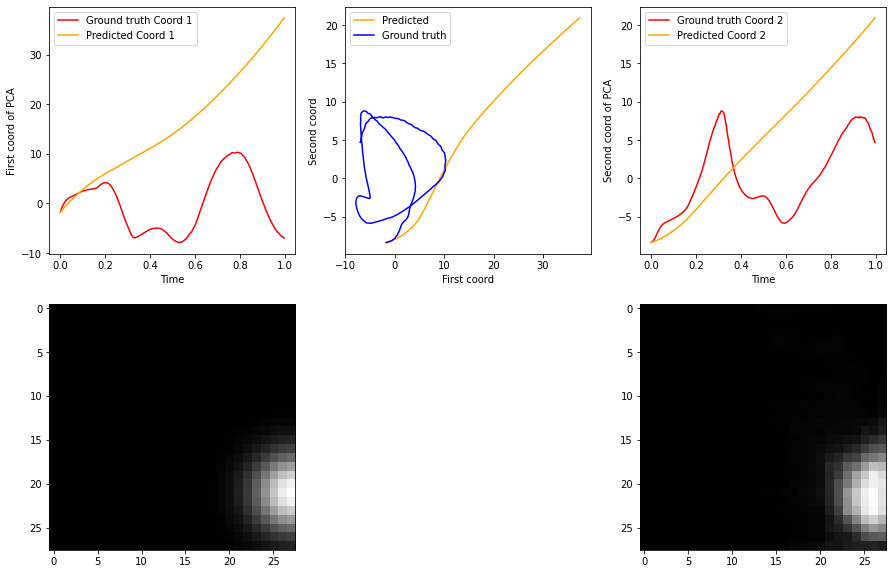

Display loss: 0.00063581:  40%|███▉      | 1199/3000 [45:16<1:06:37,  2.22s/it, Loss: 0.00043080]

The graphs at epoch 1200


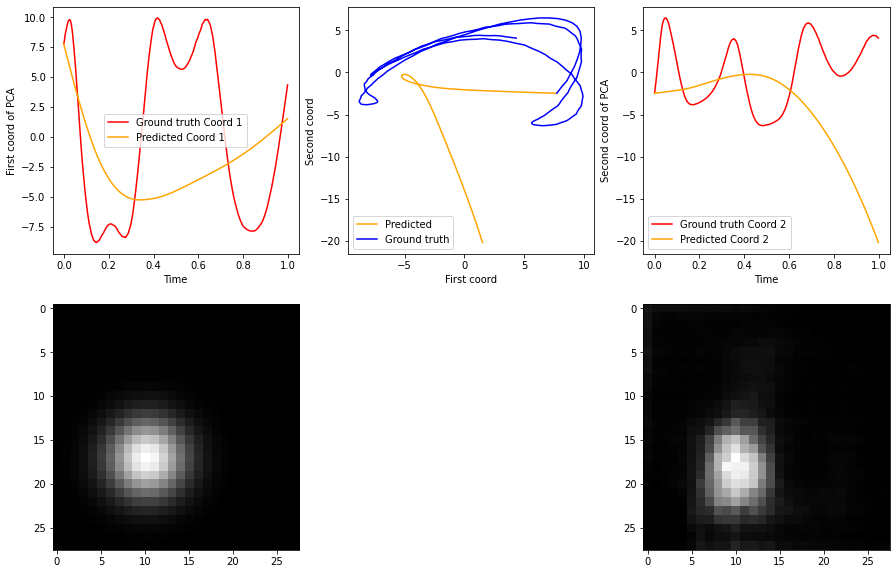

Display loss: 0.00047580:  47%|████▋     | 1399/3000 [52:48<1:05:10,  2.44s/it, Loss: 0.00027466]

The graphs at epoch 1400


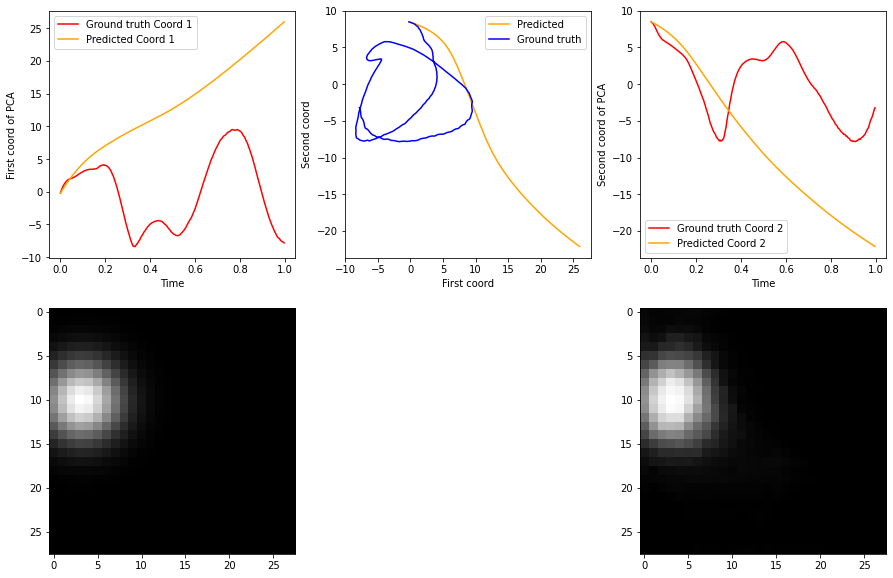

Display loss: 0.00040770:  53%|█████▎    | 1599/3000 [1:00:27<51:56,  2.22s/it, Loss: 0.00028814]

The graphs at epoch 1600


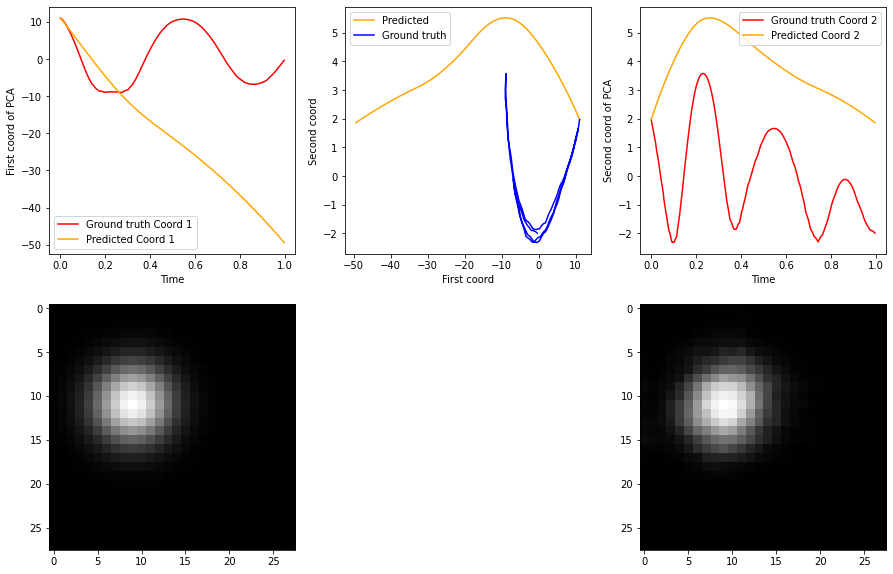

Display loss: 0.00023930:  60%|█████▉    | 1799/3000 [1:07:52<43:43,  2.18s/it, Loss: 0.00017378]  

The graphs at epoch 1800


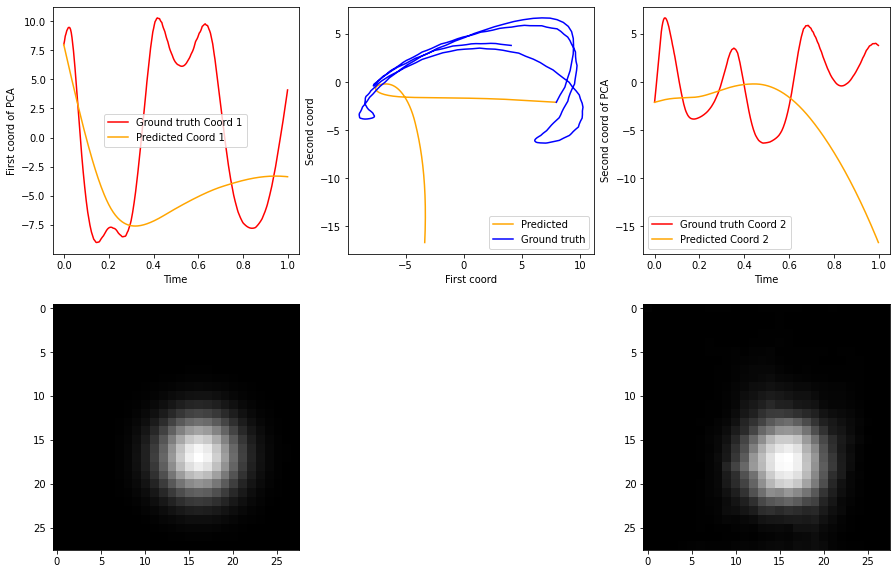

Display loss: 0.00023745:  67%|██████▋   | 1999/3000 [1:15:31<36:59,  2.22s/it, Loss: 0.00030157]

The graphs at epoch 2000


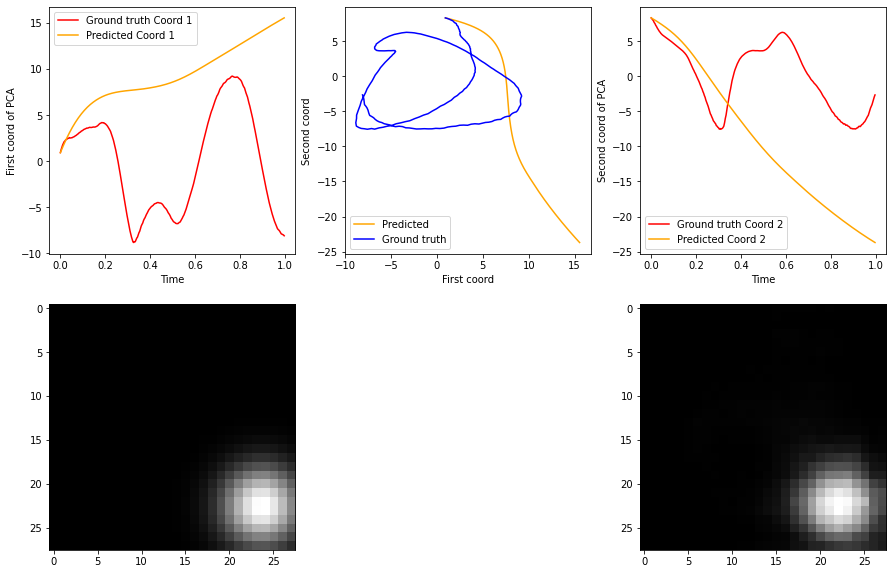

Display loss: 0.00022717:  73%|███████▎  | 2199/3000 [1:23:08<29:48,  2.23s/it, Loss: 0.00013609]

The graphs at epoch 2200


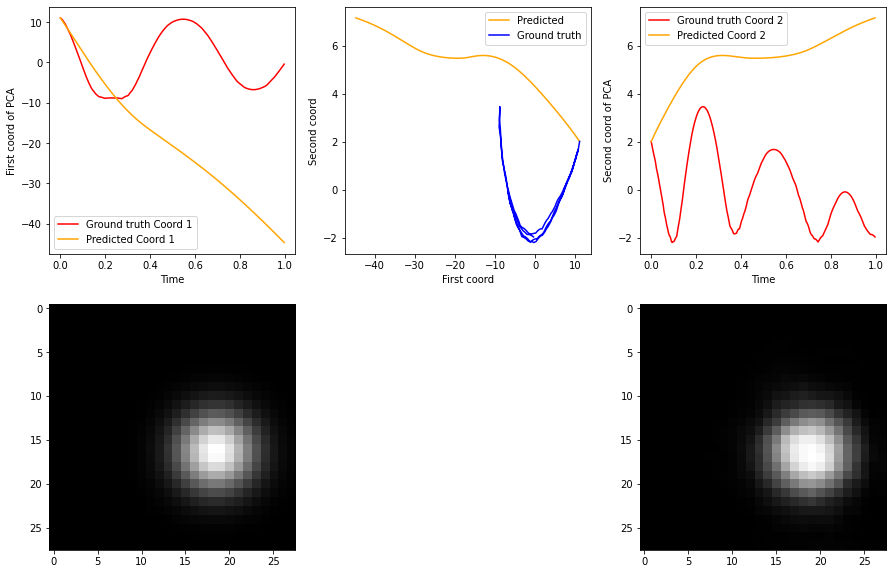

Display loss: 0.00021807:  78%|███████▊  | 2350/3000 [1:28:44<24:09,  2.23s/it, Loss: 0.00008936]

In [16]:
print("-"*50)
print("Training...")
batch_size = 32
epochs = 3000
train_convnode(conv_ode, optimizer, scheduler, epochs, batch_size, getter, loss_fn=loss_fn, display=200, display_results_fn=display_fn)